# Miguel Angel Ruiz Ortiz
## Procesamiento de Lenguaje Natural
## Tarea 2: Fundamentos de Minería de Text

In [3]:
from typing import Literal
from IPython.display import Markdown, display
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
import spacy

nltk.download("stopwords")

from nltk.corpus import stopwords

/Users/miguelruiz/Documents/Academic Stuff/NLP/Code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelruiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2- Bolsas de Palabras, Bigramas y Emociones

### Representa los documentos y clasifica con SVM similar a la Práctica 3, pero con diferentes pesados de términos.

La siguiente función lee un corpus y la clasificación de cada texto en él.

In [4]:
def getCorpus(corpus_path: Path, labels_path: Path) -> tuple[list[str]]:
    with open(corpus_path, "r") as corpus_file, open(labels_path, "r") as labels_file:
        corpus = [line for line in corpus_file]
        labels = [line for line in labels_file]

    return corpus, labels

In [ ]:
base_path = Path("../data")
mex_a3t_path = base_path / "MEX-A3T"

train_corpus_path = mex_a3t_path / "mex20_train.txt"
train_labels_path = mex_a3t_path / "mex20_train_labels.txt"
val_corpus_path = mex_a3t_path / "mex20_val.txt"
val_labels_path = mex_a3t_path / "mex20_val_labels.txt"

In [8]:
train_corpus, train_labels = getCorpus(train_corpus_path, train_labels_path)
val_corpus, val_labels = getCorpus(val_corpus_path, val_labels_path)

Número de tweets en el conjunto de entrenamiento y validación:

In [9]:
print("Entrenamiento:", len(train_corpus))
print("Validación:", len(val_corpus))

Entrenamiento: 5278
Validación: 587


Histograma de las etiquetas:

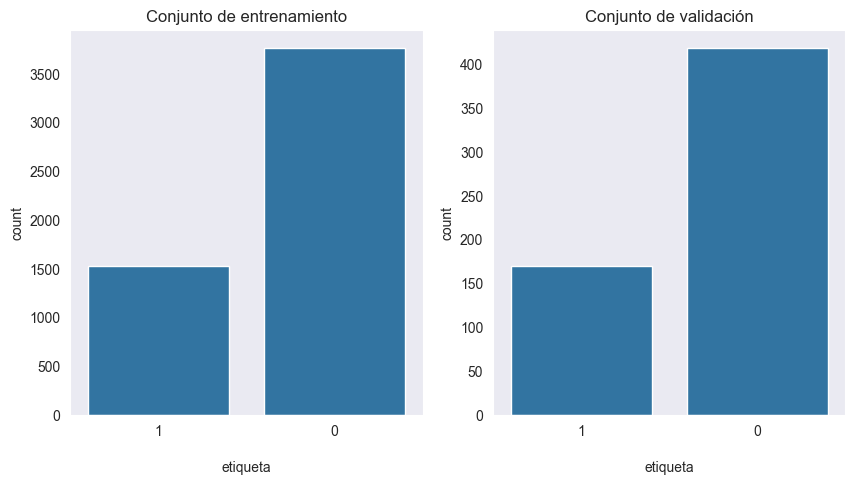

In [10]:
sns.set_style("dark") # para mejores gráficas

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=pd.DataFrame(train_labels, columns=["etiqueta"]), x="etiqueta", ax=axs[0])
sns.countplot(data=pd.DataFrame(val_labels, columns=["etiqueta"]), x="etiqueta", ax=axs[1])
axs[0].set_title("Conjunto de entrenamiento")
axs[1].set_title("Conjunto de validación")
plt.show()

Vistazo a los datos en parejas (tweet, clasificación):

In [11]:
list(zip(train_corpus[:5], train_labels[:5]))

[('@USUARIO @USUARIO @USUARIO Q se puede esperar del maricon de closet de la Yañez aun recuerdo esa ves q lo vi en zona rosa viendo quien lo levantada\n',
  '1\n'),
 ('@USUARIO La piel nueva siempre arde un poquito los primeros días... y más con este puto clima\n',
  '0\n'),
 ('Ustedes no se enamoran de mí… por tontas.\n', '1\n'),
 ('Me las va a pagar esa puta gorda roba tuits...\n', '1\n'),
 ('@USUARIO LA GENTE ES TONTA PORQUE NO SE DAN CUENTA QUE TÚ HACES A BATMAN AZUL\n',
  '0\n')]

Procesamos las etiquetas para que no tengan "\n"

In [12]:
train_labels = [int(label) for label in train_labels]
val_labels = [int(label) for label in val_labels]

Tokenizamos con TweetTokenizer. Como parámetros en el tokenizador especificamos que nos convierta a minúsculas el texto (```preserve_case=False```, que quite las palabras "@usuario" (```strip_handles=True```), y las secuencias con más de 3 caracteres iguales seguidos se cortan a longitud 3 (```reduce_len=True```).

In [13]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

train_corpus_tk = [tokenizer.tokenize(tweet) for tweet in train_corpus]
val_corpus_tk = [tokenizer.tokenize(tweet) for tweet in val_corpus]

Para la Bolsa de Palabras (BoW), implementamos una clase que tenga los métodos:
1. ``fit`` para extraer vocabulario y demás operaciones auxiliares que dependen de un conjunto de entrenamiento (lista de textos tokenizados), y regresa la matriz BoW asociada al conjunto de entrenamiento;
2. ``transform`` para convertir una lista de textos tokenizados a su matriz BoW, después de haber llamado el método ``fit``.

Los parámetros para inicializar la clase determinan el esquema de pesado (``weights_type``), si se necesitan normalizar los vectores asociados a los documentos (``normalize``), y el número de términos más frecuentes a considerar en el vocabulario de la BoW (``max_vocab_size``). Además, la clase contiene como atributos al vocabulario y la posición que le corresponde una palabra en el vocabulario en las columnas de la matriz BoW.

Para extraer el vocabulario, no se consideran stopwords por ser palabras vacías que probablemente no contribuyan a la discriminación de los tweets.

In [ ]:
def normalize_vector(vector: np.ndarray) -> np.ndarray:
    """Normalize a 1D numpy array with l2 norm"""
    norm = np.sum(vector**2) ** 0.5
    # deal with case where norm is 0
    if norm < 1e-8:
        return vector

    return vector / norm

class BagOfWords:
    def __init__(
        self,
        weights_type: Literal["binary", "tf", "tfidf"] = "binary",
        normalize: bool = False,
        max_vocab_size: int = 5000,
    ):

        if weights_type not in ["binary", "tf", "tfidf"]:
            raise ValueError(
                'Invalid weights type. Must be one of "binary", "tf" or "tfidf"'
            )

        self.weights_type = weights_type
        self.max_vocab_size = max_vocab_size
        self.normalize = normalize
        self.vocab = set()
        self.vocab_order = {}  # word -> column index in the BoW matrix
        self.word_freq = {}  # word -> frequency in the training corpus

        # only for tfidf weights type. It precalculates the IDF termns which only depend on the training corpus
        self.word_idf = {} # word -> IDF value after fit method

    def fit(self, corpus: list[list[str]]) -> np.ndarray:
        # extract vocabulary from training corpus and compute its BoW matrix

        corpus_words = []
        for doc in corpus:
            corpus_words += doc

        freq_dist = nltk.FreqDist(corpus_words)

        stopwords_es = set(stopwords.words("spanish"))

        # obtain max_vocab_size most common words that are not stopwords

        quit_stop_words = [
            (word, freq)
            for word, freq in freq_dist.most_common()
            if word not in stopwords_es
        ]

        self.word_freq = dict(quit_stop_words[: self.max_vocab_size])
        self.vocab_order = {
            word: idx
            for idx, (word, _) in enumerate(quit_stop_words[: self.max_vocab_size])
        }
        self.vocab = set(self.vocab_order.keys())

        # reset the idf values for new fit
        self.word_idf = {}

        # construct the BoW matrix
        return self.transform(corpus)

    def transform(self, corpus: list[list[str]]) -> np.ndarray:
        # compute BoW matrix for a given corpus, assuming vocabulary has been extracted

        # validate this method is called after fit method
        if len(self.vocab) == 0:
            raise ValueError("Vocabulary has not been extracted in fit method yet")

        # construct the BoW matrix
        if self.weights_type == "binary":
            bow_matrix = self.bowBinary(corpus)
        elif self.weights_type == "tf":
            bow_matrix = self.bowTF(corpus)
        else:
            # tfidf case
            bow_matrix = self.bowTFIDF(corpus)

        if self.normalize:
            for i in range(len(corpus)):
                bow_matrix[i] = normalize_vector(bow_matrix[i])

        return bow_matrix

    def bowBinary(self, corpus: list[list[str]]) -> np.ndarray:
        # compute BoW matrix with binary weights

        bow_matrix = np.zeros((len(corpus), len(self.vocab)))

        for id_doc, doc in enumerate(corpus):
            for token in set(doc):
                if token in self.vocab:
                    bow_matrix[id_doc, self.vocab_order[token]] = 1

        return bow_matrix

    def bowTF(self, corpus: list[list[str]]) -> np.ndarray:
        # compute BoW matrix with frequency weights

        bow_matrix = np.zeros((len(corpus), len(self.vocab)))

        for id_doc, doc in enumerate(corpus):
            freq_doc = nltk.FreqDist(doc)

            for token in doc:
                if token in self.vocab:
                    bow_matrix[id_doc, self.vocab_order[token]] = freq_doc[token]

        return bow_matrix

    def bowTFIDF(self, corpus: list[list[str]]) -> np.ndarray:
        # compute BoW matrix with TF-IDF weights

        bow_matrix = np.zeros((len(corpus), len(self.vocab)), dtype=float)

        freq_all_docs = {i: nltk.FreqDist(doc) for i, doc in enumerate(corpus)}

        # compute IDF for each token if it is first time (i.e., only for training phase)
        if len(self.word_idf) == 0:
            for token in self.vocab:
                if sum([1 for i in range(len(corpus)) if token in freq_all_docs[i]]) == 0:
                    print(token, self.word_freq[token])

                self.word_idf[token] = np.log(
                    len(corpus)
                    / sum([1 for i in range(len(corpus)) if token in freq_all_docs[i]])
                )

        # construct matrix
        for id_doc, doc in enumerate(corpus):
            freq_doc = freq_all_docs[id_doc]

            for token in doc:
                if token in self.vocab:
                    bow_matrix[id_doc, self.vocab_order[token]] = (
                        freq_doc[token] * self.word_idf[token]
                    )

        return bow_matrix

La siguiente función evalua el rendimiento de una BoW (forma matricial) al clasificar con una SVM. Se escoge el mejor hiperparámetro ``C`` de la SVM entre los posibles valores ``[0.05, 0.12, 0.25, 0.5, 1, 2, 4]`` utilizando validación cruzada con 5 pliegues. La función regresa la mejor SVM ya entrenada, y un diccionario con las métricas de desempeño que devuelve la función ``classification_report`` de Scikit-Learn (e.g., accuracy, recall, precision, f1)

In [33]:
def evaluate_bow(
    X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray
) -> tuple[svm.SVC, dict]:
    """Evaluates BoW matrix W using a linear SVM classifier and grid search for hyperparameter tuning"""

    grid = GridSearchCV(
        svm.SVC(kernel="linear", class_weight="balanced"),
        {"C": [0.05, 0.12, 0.25, 0.5, 1, 2, 4]},
        cv=5,
        scoring="f1_macro",
        n_jobs=-1,
    )

    best_classifier = grid.fit(X_train, y_train)

    print("Mejor parámetro:", grid.best_params_)

    y_pred_val = best_classifier.predict(X_val)

    print("Matriz de confusión:\n", confusion_matrix(y_val, y_pred_val))
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred_val))

    report_dict = classification_report(y_val, y_pred_val, output_dict=True)

    return best_classifier, report_dict

### 2.1- Evalúe BoW con pesado binario

In [16]:
bow_constructor = BagOfWords(weights_type="binary", normalize=False)
bow_tr_bin = bow_constructor.fit(train_corpus_tk)
bow_val_bin = bow_constructor.transform(val_corpus_tk)

In [17]:
classifier_bin, report_bin = evaluate_bow(
    bow_tr_bin, train_labels, bow_val_bin, val_labels
)

Mejor parámetro: {'C': 0.12}
Matriz de confusión:
 [[359  59]
 [ 40 129]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       418
           1       0.69      0.76      0.72       169

    accuracy                           0.83       587
   macro avg       0.79      0.81      0.80       587
weighted avg       0.84      0.83      0.83       587



### 2.2- Evalúe BoW con pesado frecuencia

In [18]:
bow_constructor = BagOfWords(weights_type="tf", normalize=False)
bow_tr_tf = bow_constructor.fit(train_corpus_tk)
bow_val_tf = bow_constructor.transform(val_corpus_tk)

In [19]:
classifier_tf, report_tf = evaluate_bow(
    bow_tr_tf, train_labels, bow_val_tf, val_labels
)

Mejor parámetro: {'C': 0.12}
Matriz de confusión:
 [[356  62]
 [ 44 125]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       418
           1       0.67      0.74      0.70       169

    accuracy                           0.82       587
   macro avg       0.78      0.80      0.79       587
weighted avg       0.83      0.82      0.82       587



### 2.3- Evalúe BoW con pesado TF-IDF.

In [20]:
bow_constructor = BagOfWords(weights_type="tfidf", normalize=False)
bow_tr_tfidf = bow_constructor.fit(train_corpus_tk)
bow_val_tfidf = bow_constructor.transform(val_corpus_tk)

In [21]:
classifier_tfidf, report_tfidf = evaluate_bow(
    bow_tr_tfidf, train_labels, bow_val_tfidf, val_labels
)

Mejor parámetro: {'C': 0.05}
Matriz de confusión:
 [[358  60]
 [ 67 102]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       418
           1       0.63      0.60      0.62       169

    accuracy                           0.78       587
   macro avg       0.74      0.73      0.73       587
weighted avg       0.78      0.78      0.78       587



### 2.4- Evalúe BoW con pesado binario normalizado l2

In [22]:
bow_constructor = BagOfWords(weights_type="binary", normalize=True)
bow_tr_bin_norm = bow_constructor.fit(train_corpus_tk)
bow_val_bin_norm = bow_constructor.transform(val_corpus_tk)

In [23]:
classifier_bin_norm, report_bin_norm = evaluate_bow(
    bow_tr_bin_norm, train_labels, bow_val_bin_norm, val_labels
)

Mejor parámetro: {'C': 1}
Matriz de confusión:
 [[355  63]
 [ 38 131]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       418
           1       0.68      0.78      0.72       169

    accuracy                           0.83       587
   macro avg       0.79      0.81      0.80       587
weighted avg       0.84      0.83      0.83       587



### 2.5- Evalúe BoW con pesado frecuencia normalizado l2

In [24]:
bow_constructor = BagOfWords(weights_type="tf", normalize=True)
bow_tr_tf_norm = bow_constructor.fit(train_corpus_tk)
bow_val_tf_norm = bow_constructor.transform(val_corpus_tk)

In [25]:
classifier_tf_norm, report_tf_norm = evaluate_bow(
    bow_tr_tf_norm, train_labels, bow_val_tf_norm, val_labels
)

Mejor parámetro: {'C': 1}
Matriz de confusión:
 [[356  62]
 [ 40 129]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       418
           1       0.68      0.76      0.72       169

    accuracy                           0.83       587
   macro avg       0.79      0.81      0.80       587
weighted avg       0.83      0.83      0.83       587



### 2.6- Evalúe BoW con pesado tfidf normalizado l2

In [26]:
bow_constructor = BagOfWords(weights_type="tfidf", normalize=True)
bow_tr_tfidf_norm = bow_constructor.fit(train_corpus_tk)
bow_val_tfidf_norm = bow_constructor.transform(val_corpus_tk)

In [27]:
classifier_tfidf_norm, report_tfidf_norm = evaluate_bow(
    bow_tr_tfidf_norm, train_labels, bow_val_tfidf_norm, val_labels
)

Mejor parámetro: {'C': 0.25}
Matriz de confusión:
 [[365  53]
 [ 47 122]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       418
           1       0.70      0.72      0.71       169

    accuracy                           0.83       587
   macro avg       0.79      0.80      0.79       587
weighted avg       0.83      0.83      0.83       587



### 2.7- Ponga una tabla comparativa a modo de resumen con las seis entradas anteriores.

Para las métricas *precision*, *recall* y *F1-score*, se consideró la estrategia "macro" (i.e., el promedio de los F1-scores individuales de cada clase).

In [28]:
display(
    Markdown(
        f"""
| Esquema de pesado | Accuracy | Precision | Recall | F1-Score |
|-------------------|----------|-----------|--------|----------|
| Binario | {report_bin['accuracy']:.2f} | {report_bin['macro avg']['precision']:.2f} | {report_bin['macro avg']['recall']:.2f} | {report_bin['macro avg']['f1-score']:.2f} |
| TF | {report_tf['accuracy']:.2f} | {report_tf['macro avg']['precision']:.2f} | {report_tf['macro avg']['recall']:.2f} | {report_tf['macro avg']['f1-score']:.2f} |
| TF-IDF | {report_tfidf['accuracy']:.2f} | {report_tfidf['macro avg']['precision']:.2f} | {report_tfidf['macro avg']['recall']:.2f} | {report_tfidf['macro avg']['f1-score']:.2f} |
| Binario (normalizado) | {report_bin_norm['accuracy']:.2f} | {report_bin_norm['macro avg']['precision']:.2f} | {report_bin_norm['macro avg']['recall']:.2f} | {report_bin_norm['macro avg']['f1-score']:.2f} |
| TF (normalizado) | {report_tf_norm['accuracy']:.2f} | {report_tf_norm['macro avg']['precision']:.2f} | {report_tf_norm['macro avg']['recall']:.2f} | {report_tf_norm['macro avg']['f1-score']:.2f} |
| TF-IDF (normalizado) | {report_tfidf_norm['accuracy']:.2f} | {report_tfidf_norm['macro avg']['precision']:.2f} | {report_tfidf_norm['macro avg']['recall']:.2f} | {report_tfidf_norm['macro avg']['f1-score']:.2f} |
"""
    )
)


| Esquema de pesado | Accuracy | Precision | Recall | F1-Score |
|-------------------|----------|-----------|--------|----------|
| Binario | 0.83 | 0.79 | 0.81 | 0.80 |
| TF | 0.82 | 0.78 | 0.80 | 0.79 |
| TF-IDF | 0.78 | 0.74 | 0.73 | 0.73 |
| Binario (normalizado) | 0.83 | 0.79 | 0.81 | 0.80 |
| TF (normalizado) | 0.83 | 0.79 | 0.81 | 0.80 |
| TF-IDF (normalizado) | 0.83 | 0.79 | 0.80 | 0.79 |


### 2.8- De las configuraciones anteriores elija la mejor y evalúela con más y menos términos (e.g., 1000 y 7000). Ponga una tabla dónde compare tres configuraciones distintas.

Podemos observar que los mejores pesados fueron binario, binario normalizado y por frecuencias (TF) normalizado. Vamos a escoger binario normalizado para los siguientes experimentos con 500 y 7000 palabras más frecuentes para el vocabulario.

In [52]:
bow_constructor_2 = BagOfWords(weights_type="binary", normalize=True, max_vocab_size=500)
bow_constructor_3 = BagOfWords(weights_type="binary", normalize=True, max_vocab_size=7000)

In [53]:
bow_tr_bin_norm_2 = bow_constructor_2.fit(train_corpus_tk)
bow_val_bin_norm_2 = bow_constructor_2.transform(val_corpus_tk)

bow_tr_bin_norm_3 = bow_constructor_3.fit(train_corpus_tk)
bow_val_bin_norm_3 = bow_constructor_3.transform(val_corpus_tk)

In [54]:
classifier_bin_norm_2, report_bin_norm_2 = evaluate_bow(
    bow_tr_bin_norm_2, train_labels, bow_val_bin_norm_2, val_labels
)

Mejor parámetro: {'C': 1}
Matriz de confusión:
 [[359  59]
 [ 42 127]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       418
           1       0.68      0.75      0.72       169

    accuracy                           0.83       587
   macro avg       0.79      0.81      0.80       587
weighted avg       0.83      0.83      0.83       587



In [84]:
classifier_bin_norm_3, report_bin_norm_3 = evaluate_bow(
    bow_tr_bin_norm_3, train_labels, bow_val_bin_norm_3, val_labels
)

Mejor parámetro: {'C': 1}
Matriz de confusión:
 [[354  64]
 [ 39 130]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       418
           1       0.67      0.77      0.72       169

    accuracy                           0.82       587
   macro avg       0.79      0.81      0.79       587
weighted avg       0.83      0.82      0.83       587



In [85]:
display(
    Markdown(
        f"""
| Tamaño de vocabulario | Accuracy | Precision | Recall | F1-Score |
|----------------------|----------|-----------|--------|----------|
| 500 | {report_bin_norm_2['accuracy']:.2f} | {report_bin_norm_2['macro avg']['precision']:.2f} | {report_bin_norm_2['macro avg']['recall']:.2f} | {report_bin_norm_2['macro avg']['f1-score']:.2f} |
| 5000 | {report_bin_norm['accuracy']:.2f} | {report_bin_norm['macro avg']['precision']:.2f} | {report_bin_norm['macro avg']['recall']:.2f} | {report_bin_norm['macro avg']['f1-score']:.2f} |
| 7000 | {report_bin_norm_3['accuracy']:.2f} | {report_bin_norm_3['macro avg']['precision']:.2f} | {report_bin_norm_3['macro avg']['recall']:.2f} | {report_bin_norm_3['macro avg']['f1-score']:.2f} |
"""
    )
)


| Tamaño de vocabulario | Accuracy | Precision | Recall | F1-Score |
|----------------------|----------|-----------|--------|----------|
| 500 | 0.83 | 0.79 | 0.81 | 0.80 |
| 5000 | 0.83 | 0.79 | 0.81 | 0.80 |
| 7000 | 0.82 | 0.79 | 0.81 | 0.79 |


### 2.9- Utilice el recurso léxico del Consejo Nacional de Investigación de Canadá llamado ["EmoLex"](https://www.saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) para construir una "Bolsa de Emociones" de los Tweets de agresividad (debe usar EmoLex en Español). Para esto, una estrategia sencilla sería enmascarar (sustituir) cada palabra con su emoción, y después construir la Bolsa de Emociones (BoE).

In [55]:
emolex_path = base_path / "NRC-Emotion-Lexicon"
emolex_spanish_path = emolex_path / "OneFilePerLanguage" / "Spanish-NRC-EmoLex.txt"

emolex = pd.read_csv(emolex_spanish_path, sep='\t')

emolex.head()

,English Word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Spanish Word
0,aback,0,0,0,0,0,0,0,0,0,0,detrás
1,abacus,0,0,0,0,0,0,0,0,0,1,ábaco
2,abandon,0,0,0,1,0,1,0,1,0,0,abandonar
3,abandoned,1,0,0,1,0,1,0,1,0,0,abandonado
4,abandonment,1,0,0,1,0,1,0,1,1,0,abandono


Hacemos un mapeo de palabras a sus emociones asociadas en EmoLex.

In [56]:
emotions = [
    "anger",
    "anticipation",
    "disgust",
    "fear",
    "joy",
    "surprise",
    "trust",
    "sadness",
    "positive",
    "negative",
]

word_to_emotions = {
    row["Spanish Word"]: [emotion for emotion in emotions if row[emotion] == 1]
    for _, row in emolex.iterrows()
}

list(word_to_emotions.items())[:5]

[('detrás', []),
 ('ábaco', ['trust']),
 ('abandonar', ['negative']),
 ('abandonado', ['anger', 'sadness', 'negative']),
 ('abandono', ['anger', 'fear', 'surprise', 'sadness', 'negative'])]

Usamos lematización para que poder hacer match con las palabras en EmoLex

In [57]:
nlp = spacy.load("es_core_news_sm")

def lemmatize_spanish(text: str) -> list[str]:
    """ Function to lemmatize text
    """
    doc = nlp(text)
    return [token.lemma_ for token in doc]

In [58]:
tr_lemmas = [lemmatize_spanish(tweet.lower()) for tweet in train_corpus]
val_lemmas = [lemmatize_spanish(tweet.lower()) for tweet in val_corpus]

Enmascaramos cada palabra por sus emocines a través de nuestro mapeo anterior, e ignoramos las que no se pueden mapear.

In [59]:
def get_doc_emotions(doc: list[str]) -> list[str]:
    """ Function to get emotions from a document
    """
    emotions = []

    for token in doc:
        if token in word_to_emotions and len(word_to_emotions[token]) > 0:
            emotions += word_to_emotions[token]

    return emotions

tr_masked = [get_doc_emotions(doc) for doc in tr_lemmas]
val_masked = [get_doc_emotions(doc) for doc in val_lemmas]

In [60]:
tr_masked[:8]

[['anticipation', 'joy', 'surprise', 'trust', 'positive'],
 [],
 ['anticipation'],
 ['anger', 'anticipation', 'joy', 'trust', 'positive', 'disgust', 'negative'],
 ['negative', 'anticipation', 'sadness'],
 ['trust', 'positive'],
 [],
 ['anticipation',
  'anticipation',
  'anger',
  'anticipation',
  'disgust',
  'fear',
  'joy',
  'surprise',
  'trust',
  'sadness',
  'positive',
  'negative',
  'joy',
  'surprise',
  'trust',
  'positive',
  'negative',
  'negative']]

Bolsa de Emociones (BoE) con pesado binario normalizado

In [61]:
bow_constructor = BagOfWords(weights_type="binary", normalize=True)

boe_emolex_tr_bin = bow_constructor.fit(tr_masked)
boe_emolex_val_bin = bow_constructor.transform(val_masked)

In [62]:
boe_emolex_tr_bin[:5, :]

array([[0.        , 0.4472136 , 0.4472136 , 0.4472136 , 0.        ,
        0.4472136 , 0.        , 0.        , 0.        , 0.4472136 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.37796447, 0.37796447, 0.37796447, 0.37796447, 0.        ,
        0.37796447, 0.37796447, 0.37796447, 0.        , 0.        ],
       [0.57735027, 0.57735027, 0.        , 0.        , 0.57735027,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

### 2.10- Usa tu BoE de alguna forma y clasifica con SVM. Ponga una tabla comparativa a modo de resumen con tres pesados (binario, TF, TF-IDF), normalize cada uno si lo cree conveniente.

Evaluación de pesado Binario

In [63]:
classifier_boe_emolex_bin, report_boe_emolex_bin = evaluate_bow(
    boe_emolex_tr_bin, train_labels, boe_emolex_val_bin, val_labels
)

Mejor parámetro: {'C': 0.05}
Matriz de confusión:
 [[327  91]
 [108  61]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       418
           1       0.40      0.36      0.38       169

    accuracy                           0.66       587
   macro avg       0.58      0.57      0.57       587
weighted avg       0.65      0.66      0.66       587



Pesado de frecuencia normalizado

In [64]:
bow_constructor = BagOfWords(weights_type="tf", normalize=True)

boe_emolex_tr_tf = bow_constructor.fit(tr_masked)
boe_emolex_val_tf = bow_constructor.transform(val_masked)

classifier_boe_emolex_tf, report_boe_emolex_tf = evaluate_bow(
    boe_emolex_tr_tf, train_labels, boe_emolex_val_tf, val_labels
)

Mejor parámetro: {'C': 0.05}
Matriz de confusión:
 [[336  82]
 [110  59]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       418
           1       0.42      0.35      0.38       169

    accuracy                           0.67       587
   macro avg       0.59      0.58      0.58       587
weighted avg       0.66      0.67      0.66       587



Pesado TF-IDF normalizado

In [65]:
bow_constructor = BagOfWords(weights_type="tfidf", normalize=True)

boe_emolex_tr_tfidf = bow_constructor.fit(tr_masked)
boe_emolex_val_tfidf = bow_constructor.transform(val_masked)

classifier_boe_emolex_tfidf, report_boe_emolex_tfidf = evaluate_bow(
    boe_emolex_tr_tfidf, train_labels, boe_emolex_val_tfidf, val_labels
)

Mejor parámetro: {'C': 0.05}
Matriz de confusión:
 [[328  90]
 [109  60]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       418
           1       0.40      0.36      0.38       169

    accuracy                           0.66       587
   macro avg       0.58      0.57      0.57       587
weighted avg       0.65      0.66      0.65       587



Tabla comparativa

In [66]:
display(
    Markdown(
        f"""
| Esquema de pesado | Accuracy | Precision | Recall | F1-Score |
|-------------------|----------|-----------|--------|----------|
| Binario | {report_boe_emolex_bin['accuracy']:.2f} | {report_boe_emolex_bin['macro avg']['precision']:.2f} | {report_boe_emolex_bin['macro avg']['recall']:.2f} | {report_boe_emolex_bin['macro avg']['f1-score']:.2f} |
| TF | {report_boe_emolex_tf['accuracy']:.2f} | {report_boe_emolex_tf['macro avg']['precision']:.2f} | {report_boe_emolex_tf['macro avg']['recall']:.2f} | {report_boe_emolex_tf['macro avg']['f1-score']:.2f} |
| TF-IDF | {report_boe_emolex_tfidf['accuracy']:.2f} | {report_boe_emolex_tfidf['macro avg']['precision']:.2f} | {report_boe_emolex_tfidf['macro avg']['recall']:.2f} | {report_boe_emolex_tfidf['macro avg']['f1-score']:.2f} |
"""
    )
)


| Esquema de pesado | Accuracy | Precision | Recall | F1-Score |
|-------------------|----------|-----------|--------|----------|
| Binario | 0.66 | 0.58 | 0.57 | 0.57 |
| TF | 0.67 | 0.59 | 0.58 | 0.58 |
| TF-IDF | 0.66 | 0.58 | 0.57 | 0.57 |


# 3- Recurso Lingüístico de Emociones Mexicano

### 3.1- Utilice el recurso léxico llamado ["Spanish Emotion Lexicon (SEL)"](https://www.cic.ipn.mx/~sidorov/#SEL) del Dr. Grigori Sidorov, profesor del Centro de Investigación en Computación (CIC) del Instituto Politécnico Nacional, para enmascarar cada palabra con su emoción, y después construir la Bolsa de Emociones con algún pesado (e.g., binario, TF, TF-IDF). Proponga alguna estrategia para incorporar el "valor" del "Probability Factor of Affective use" en su representación vectorial del documento. Evalúa y escribe una tabla comparativa a modo de resumen con al menos tres pesados: binario, frecuencia, TF-IDF. Normalize cada pesado según lo crea conveniente.

Leemos el archivo que contiene SEL mediante Pandas

In [67]:
sel_path = base_path / "SpanishEmotionLexicon" / "SEL.txt"

sel = pd.read_csv(sel_path, sep='\t', encoding='latin1')

sel.tail(10)

,Palabra,PFA,Categoría
2026,tétrico,0.199,Tristeza
2027,tormento,0.530,Tristeza
2028,triste,0.966,Tristeza
2029,tristemente,0.966,Tristeza
2030,tristeza,0.966,Tristeza
2031,trizas,0.464,Tristeza
2032,vejación,0.297,Tristeza
2033,vejar,0.396,Tristeza
2034,vergonzoso,0.231,Tristeza
2035,zangarriana,0.530,Tristeza


In [68]:
sel.rename(columns={" PFA": "PFA"}, inplace=True) # Quitamos el espacio en blanco del nombre de la columna

Emociones consideradas:

In [69]:
sel["Categoría"].unique()

array(['Alegría', 'Enojo', 'Miedo', 'Repulsión', 'Sorpresa', 'Tristeza'],
      dtype=object)

Construimos un mapeo "palabra" -> ("emoción", PFA), donde el PFA es el Probability Factor of Affective use.

In [70]:
word_to_emotion_sel = {
    row["Palabra"]: (row["Categoría"], row["PFA"])
    for _, row in sel.iterrows()
}

list(word_to_emotion_sel.items())[:5]

[('abundancia', ('Alegría', 0.83)),
 ('acabalar', ('Alegría', 0.396)),
 ('acallar', ('Alegría', 0.198)),
 ('acatar', ('Alegría', 0.198)),
 ('acción', ('Alegría', 0.397))]

Obtenemos las máscaras de los tweets

In [71]:
tr_masked = [
    [word_to_emotion_sel[token][0] for token in doc if token in word_to_emotion_sel]
    for doc in tr_lemmas
]
val_masked = [
    [word_to_emotion_sel[token][0] for token in doc if token in word_to_emotion_sel]
    for doc in val_lemmas
]

Las siguientes funciones realizan lo siguiente:
1.  ``get_pfa_matrix``: construir una matriz con entradas PFA_ij, la suma de los PFA de cada palabra en el tweet i que asociada a la emoción j.
2.  ``merge_boe_and_pfa``: dada la matriz PFA y la matriz BoE, se hace la multiplicación entrada por entrada (*element wise*) de ambas matrices, y se normaliza cada renglón de la matriz resultante.

In [72]:
def get_pfa_matrix(docs: list[list[str]], emotions_order: dict[str, int]) -> np.ndarray:
    """ Function to construct the PFA matrix. emotions_order is the map "emotion" -> "column index"
    """
    pfa_matrix = np.zeros((len(docs), len(emotions_order)))

    for i, doc in enumerate(docs):
        for token in doc:
            if token in word_to_emotion_sel:
                emotion, pfa = word_to_emotion_sel[token]
                pfa_matrix[i, emotions_order[emotion]] += pfa

    return pfa_matrix

def merge_boe_and_pfa(docs: list[list[str]], boe_matrix: np.ndarray, emotions_order: dict[str, int]) -> np.ndarray:
    """ Function to merge BoE and PFA matrices, which is the element-wise product of both matrices and normalize each row
    """
    pfa_matrix = get_pfa_matrix(docs, emotions_order)

    merged = boe_matrix*pfa_matrix # element wise product

    # normalize each row
    for i in range(merged.shape[0]):
        merged[i] = normalize_vector(merged[i])

    return merged


Evaluación de BOE con pesado Binario

In [73]:
# Bag of Emotions (BoE) construction
bow_constructor = BagOfWords(weights_type="binary", normalize=True)

boe_sel_tr_bin = bow_constructor.fit(tr_masked)
boe_sel_val_bin = bow_constructor.transform(val_masked)

# add Probability Factor of Affective use (PFA) to the BoE matrix
boe_pfa_tr_bin = merge_boe_and_pfa(tr_lemmas, boe_sel_tr_bin, bow_constructor.vocab_order)
boe_pfa_val_bin = merge_boe_and_pfa(val_lemmas, boe_sel_val_bin, bow_constructor.vocab_order)

In [74]:
classifier_boe_pfa_bin, report_boe_pfa_bin = evaluate_bow(
    boe_pfa_tr_bin, train_labels, boe_pfa_val_bin, val_labels
)

Mejor parámetro: {'C': 2}
Matriz de confusión:
 [[166 252]
 [ 60 109]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.40      0.52       418
           1       0.30      0.64      0.41       169

    accuracy                           0.47       587
   macro avg       0.52      0.52      0.46       587
weighted avg       0.61      0.47      0.49       587



Evaluación de BOE con pesado de frecuencia

In [75]:
bow_constructor = BagOfWords(weights_type="tf", normalize=True)

boe_sel_tr_tf = bow_constructor.fit(tr_masked)
boe_sel_val_tf = bow_constructor.transform(val_masked)

# add Probability Factor of Affective use (PFA) to the BoE matrix
boe_pfa_tr_tf = merge_boe_and_pfa(tr_lemmas, boe_sel_tr_tf, bow_constructor.vocab_order)
boe_pfa_val_tf = merge_boe_and_pfa(val_lemmas, boe_sel_val_tf, bow_constructor.vocab_order)

classifier_boe_pfa_tf, report_boe_pfa_tf = evaluate_bow(
    boe_pfa_tr_tf, train_labels, boe_pfa_val_tf, val_labels
)

Mejor parámetro: {'C': 4}
Matriz de confusión:
 [[166 252]
 [ 60 109]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.40      0.52       418
           1       0.30      0.64      0.41       169

    accuracy                           0.47       587
   macro avg       0.52      0.52      0.46       587
weighted avg       0.61      0.47      0.49       587



Evaluación de BOE con pesado TF-IDF

In [76]:
bow_constructor = BagOfWords(weights_type="tfidf", normalize=True)

boe_sel_tr_tfidf = bow_constructor.fit(tr_masked)
boe_sel_val_tfidf = bow_constructor.transform(val_masked)

# add Probability Factor of Affective use (PFA) to the BoE matrix
boe_pfa_tr_tfidf = merge_boe_and_pfa(tr_lemmas, boe_sel_tr_tfidf, bow_constructor.vocab_order)
boe_pfa_val_tfidf = merge_boe_and_pfa(val_lemmas, boe_sel_val_tfidf, bow_constructor.vocab_order)

classifier_boe_pfa_tfidf, report_boe_pfa_tfidf = evaluate_bow(
    boe_pfa_tr_tfidf, train_labels, boe_pfa_val_tfidf, val_labels
)

Mejor parámetro: {'C': 2}
Matriz de confusión:
 [[161 257]
 [ 57 112]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.74      0.39      0.51       418
           1       0.30      0.66      0.42       169

    accuracy                           0.47       587
   macro avg       0.52      0.52      0.46       587
weighted avg       0.61      0.47      0.48       587



Tabla comparativa

In [77]:
display(
    Markdown(
        f"""
| Esquema de pesado | Accuracy | Precision | Recall | F1-Score |
|-------------------|----------|-----------|--------|----------|
| Binario | {report_boe_pfa_bin['accuracy']:.2f} | {report_boe_pfa_bin['macro avg']['precision']:.2f} | {report_boe_pfa_bin['macro avg']['recall']:.2f} | {report_boe_pfa_bin['macro avg']['f1-score']:.2f} |
| TF | {report_boe_pfa_tf['accuracy']:.2f} | {report_boe_pfa_tf['macro avg']['precision']:.2f} | {report_boe_pfa_tf['macro avg']['recall']:.2f} | {report_boe_pfa_tf['macro avg']['f1-score']:.2f} |
| TF-IDF | {report_boe_pfa_tfidf['accuracy']:.2f} | {report_boe_pfa_tfidf['macro avg']['precision']:.2f} | {report_boe_pfa_tfidf['macro avg']['recall']:.2f} | {report_boe_pfa_tfidf['macro avg']['f1-score']:.2f} |
"""
    )
)


| Esquema de pesado | Accuracy | Precision | Recall | F1-Score |
|-------------------|----------|-----------|--------|----------|
| Binario | 0.47 | 0.52 | 0.52 | 0.46 |
| TF | 0.47 | 0.52 | 0.52 | 0.46 |
| TF-IDF | 0.47 | 0.52 | 0.52 | 0.46 |


### 3.2- En un comentario aparte, discuta sobre la estrategía que utilizó para incorporar el "Probability Factor of Affective use". No más de 5 renglones.

Para obtener la "fuerza" de asociación de un tweet con una emoción, podemos sumar el PFA de las palabras que están en el tweet (lematizadas) y que se relacionan con dicha emoción. Esto sería una BoE con una estrategia de pesado que generaliza a la del pesado con frecuencias (pues se obtiene cuando todas las relaciones "palabra" -> "emoción" tienen PFA igual a 1). Para obtener una mezcla de esta matriz PFA y la BoE usual, podemos multiplicar entrada por entrada ambas matrices. De esta manera, la entrada (i,j) de la matriz resultante es ``(suma_PFA)*(peso_BOE)``, lo cual es algo natural para establecer un peso final a la asociación del tweet i con la emoción j. Al final normalizamos cada renglón para que cada tweet tenga un vector unitario asociado.

# 4- ¿Podemos mejorar con bigramas?

### 4.1- Hacer un experimento dónde concatene una buena BoW según sus experimentos anteriores con otra BoW construida a partir de los 1000 bigramas más frecuentes.

In [78]:
def bigrams(doc: list[str]) -> list[str]:
    """ Function to get bigrams from a tokenized document
    """
    
    return [(doc[i], doc[i+1]) for i in range(len(doc)-1)]

In [79]:
tr_bigrams = [list(bigrams(doc)) for doc in train_corpus_tk]
val_bigrams = [list(bigrams(doc)) for doc in val_corpus_tk]

BoW con los 1000 bigramas más frecuentes, usando pesado binario normalizado:

In [80]:
bow_constructor = BagOfWords(weights_type="binary", normalize=True, max_vocab_size=1000)

bow_bigrams_tr = bow_constructor.fit(tr_bigrams)
bow_bigrams_val = bow_constructor.transform(val_bigrams)

Concatenamos y evaluamos

In [81]:
bow_terms_bigrams_tr = np.concatenate((bow_tr_bin_norm_2, bow_bigrams_tr), axis=1)
bow_terms_bigrams_val = np.concatenate((bow_val_bin_norm_2, bow_bigrams_val), axis=1)

classifier_terms_bigrams, report_terms_bigrams = evaluate_bow(
    bow_terms_bigrams_tr, train_labels, bow_terms_bigrams_val, val_labels
)

Mejor parámetro: {'C': 0.25}
Matriz de confusión:
 [[361  57]
 [ 41 128]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       418
           1       0.69      0.76      0.72       169

    accuracy                           0.83       587
   macro avg       0.79      0.81      0.80       587
weighted avg       0.84      0.83      0.84       587



### 4.2- Hacer un experimento con las Bolsas de Emociones, Bolsa de Palabras y Bolsa de Bigramas; usted elige las dimensionalidades. Para construir la representación final del documento utilice la concatenación de las representaciones según sus observaciones (e.g., Bolsa de Palabras + Bolsa de Bigramas + Bolsa de Sentimientos de Canadá + Bolsa de Sentimientos de Grigori), y aliméntelas a un SVM.

En las diferentes bolsas de palabras, bigramas y emociones se consideró el pesado binario normalizado, pues tuvo buen desempeño en general en los experimentos realizados.

In [83]:
aug_matrix_tr = np.concatenate((bow_tr_bin_norm_2, bow_bigrams_tr, boe_emolex_tr_bin, boe_pfa_tr_bin), axis=1)
aug_matrix_val = np.concatenate((bow_val_bin_norm_2, bow_bigrams_val, boe_emolex_val_bin, boe_pfa_val_bin), axis=1)

classifier_terms_bigrams, report_terms_bigrams = evaluate_bow(
    aug_matrix_tr, train_labels, aug_matrix_val, val_labels
)

Mejor parámetro: {'C': 0.5}
Matriz de confusión:
 [[350  68]
 [ 41 128]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       418
           1       0.65      0.76      0.70       169

    accuracy                           0.81       587
   macro avg       0.77      0.80      0.78       587
weighted avg       0.83      0.81      0.82       587



### 4.3- Elabore conclusiones sobre toda esta Tarea, incluyendo observaciones, comentarios y posibles mejoras futuras. Discuta el comportamiento de la BoW de usar solo palabras a integrar bigramas, y luego a integrar todo. ¿Ayudó? o ¿empeoró?. Discuta también brevemente el costo computacional de los experimentos ¿Valió la pena tener todo?. Sea breve: todo en NO más de dos párrafos.

En los experimentos de la BoW con diferentes pesados se observó que los mejores para esta tarea fueron el pesado binario, binario normalizado y de frecuencias normalizado, con un accuracy del 83%, precision del 79%, recall del 81% y F1 score del 80%. Tomando en pesado binario normalizado como base, después se notó que con un número modesto de palabras en el vocabulario, tomando las 500 más frecuentes, se obtenían exactamente los mismos resultados. Por otro lado, al subir el número de palabras a 7000, empeoró en un punto porcentual el accuracy y el F1-score, por lo que no ayuda aumentar el vocabulario al menos para esta tarea. Tal vez este comportamiento se obtuvo debido a que nosotros NO consideramos stopwords, y de haberlas considerado tal vez sí hubieramos visto un cambio al aumentar el vocabulario (pues las palabras más frecuentes son stopwords).

En cuento a las bolsas de emociones con EmoLex y SEL, vimos que obtenían métricas más bajas (accuracy de 66-67% con EmoLex y 47% con SEL). Esto es razonable pues ambos recursos léxicos no tenían tantas palabras mapeadas a una emoción, lo que hacía que un tweet (que tiene en general pocas palabras) tenga muy pocas emociones asociadas e incluso muchos tweets sin ninguna emoción asociada. Finalmente, al concatenar la BoW con los bigramas y también con las bolsas de emociones, se observó que se seguían obteniendo métricas similares a la BoW normal con 500 palabras en el vocabulario. Por lo que no valió la pena integrar estos acercamientos extras para resolver el problema. El costo computacional aumentaba mucho conforme aumentaba la dimensión, por ejemplo cuando consideramos 7000 palabras el modelo se entrenó en local durante 80 minutos. Mientras que con 500 palabras se entrenaba en 1 minuto y ya se obtenían las mejores métricas de entre todos estos experimentos.